# Finding the best parameters for clustering

In [1]:
import sys
import os


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
print(sys.path[-1])

/home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject


In [2]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data")
H5AD_V2_DIR = os.path.join(
    DATA_DIR, "abc_atlas", "expression_matrices", "WMB-10Xv2", "20230630"
)
H5AD_V3_DIR = os.path.join(
    DATA_DIR, "abc_atlas", "expression_matrices", "WMB-10Xv3", "20230630"
)


print(f"{'BASE_DIR':<15}{BASE_DIR}")
print(f"{'DATA_DIR':<15}{DATA_DIR}")
print(f"{'H5AD_V2_DIR':<15}{H5AD_V2_DIR}")
print(f"{'H5AD_V3_DIR':<15}{H5AD_V3_DIR}")

BASE_DIR       /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject
DATA_DIR       /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject/data
H5AD_V2_DIR    /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject/data/abc_atlas/expression_matrices/WMB-10Xv2/20230630
H5AD_V3_DIR    /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject/data/abc_atlas/expression_matrices/WMB-10Xv3/20230630


In [3]:
hy_v2_path = os.path.join(
    H5AD_V2_DIR,
    "WMB-10Xv2-HY-log2.h5ad"
)
hy_v3_path = os.path.join(
    H5AD_V3_DIR,
    "WMB-10Xv3-HY-log2.h5ad"
)

print(f"{'hy_v2_path':<15}{hy_v2_path}")
print(f"{'hy_v3_path':<15}{hy_v3_path}")

hy_v2_path     /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject/data/abc_atlas/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-HY-log2.h5ad
hy_v3_path     /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject/data/abc_atlas/expression_matrices/WMB-10Xv3/20230630/WMB-10Xv3-HY-log2.h5ad


In [4]:
from src.utils import load_data, find_elbow_pcs
from src.clustering import evaluate_dbscan_clustering, plot_parameter_optimization, run_dbscan_opt

import scanpy as sc
import numpy as np
from sklearn.cluster import DBSCAN
from tqdm import tqdm
import gc

In [5]:
gc.collect()

0

In [6]:
hy_v2 = load_data(hy_v2_path, backed="r")
hy_v3 = load_data(hy_v3_path, backed="r")

# on the `n` most variant genes and `m` randomly selected cells

## step 0: default preprocessing

In [7]:
seed = 42
n = 2_000
m = 5_000
scale_max_val = 10
np.random.seed(seed)

# Downsampling
indices = np.random.choice(
    hy_v2.shape[0], size=m, replace=False
)
adata = hy_v2[indices, :].to_memory()

# Gene selection
sc.pp.highly_variable_genes(adata, n_top_genes=n, flavor="seurat")
adata = adata[:, adata.var.highly_variable].copy()

sc.pp.scale(adata, max_value=scale_max_val)

/usr/lib/python3.12/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


## step 1: PCA - best components

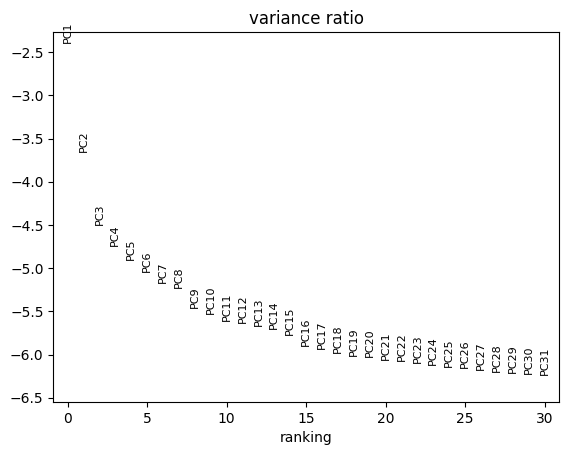

In [8]:
sc.tl.pca(adata, svd_solver="arpack", random_state=seed)
sc.pl.pca_variance_ratio(adata, log=True)

In [9]:
elbow = find_elbow_pcs(adata.uns["pca"]["variance_ratio"])
print(f"Elbow point for PCA: {elbow}")

Elbow point for PCA: 4


## step 2: nearest neighbors distance matrix and neighborooh graph of observations

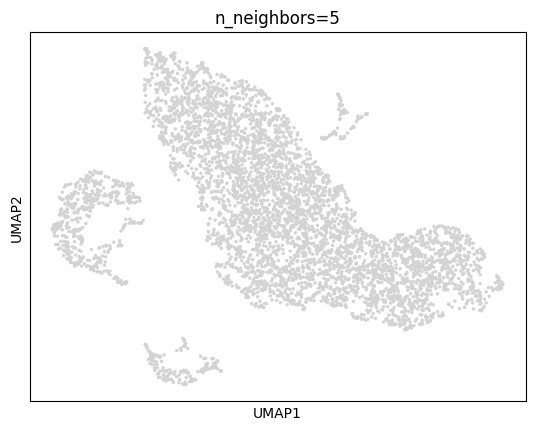

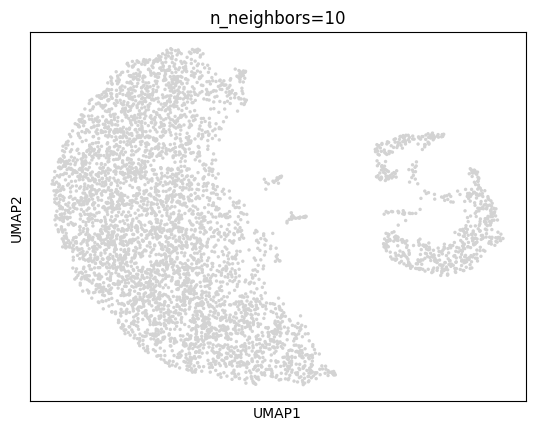

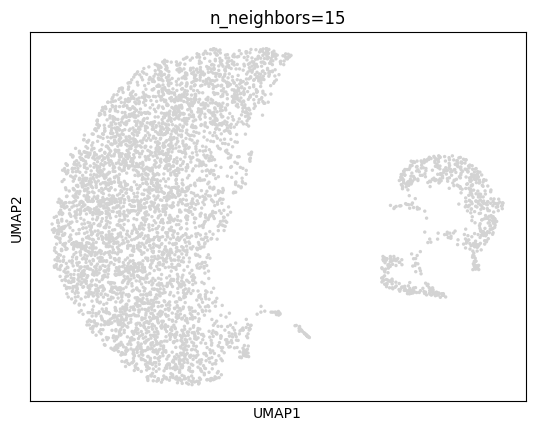

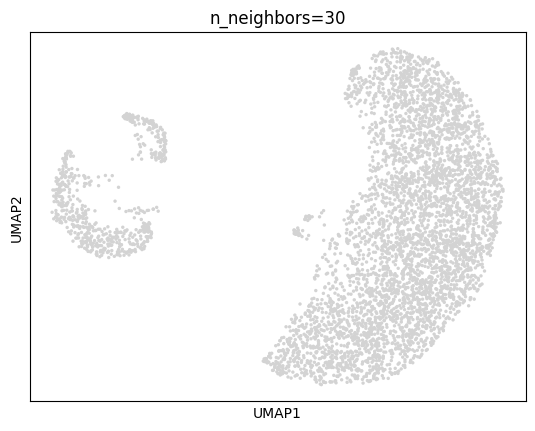

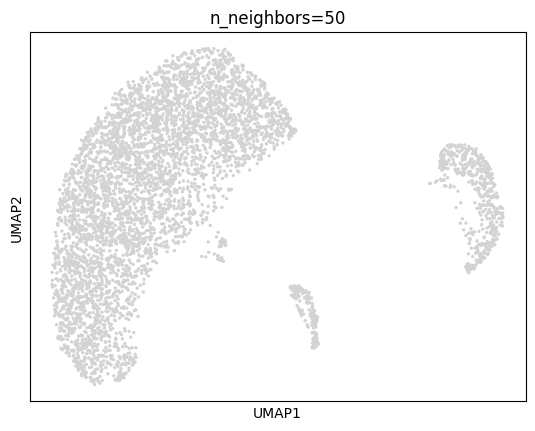

In [10]:
for n in [5, 10, 15, 30, 50]:
    sc.pp.neighbors(adata, n_neighbors=n, n_pcs=elbow)
    sc.tl.umap(adata)
    sc.pl.umap(adata, title=f"n_neighbors={n}")

Selecting `n_neighbors=15` seems optimal, since the overall structure looks more cohesive compared to smaller values, while larger values are merging the data more aggressively. 

In [11]:
n_neighbors = 15
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=elbow)

## step 3: optimizing DBSCAN parameters for noise detection


Running DBSCAN optimization with pca embeddings...


Optimizing PCA: 100%|██████████| 8/8 [01:22<00:00, 10.37s/it]


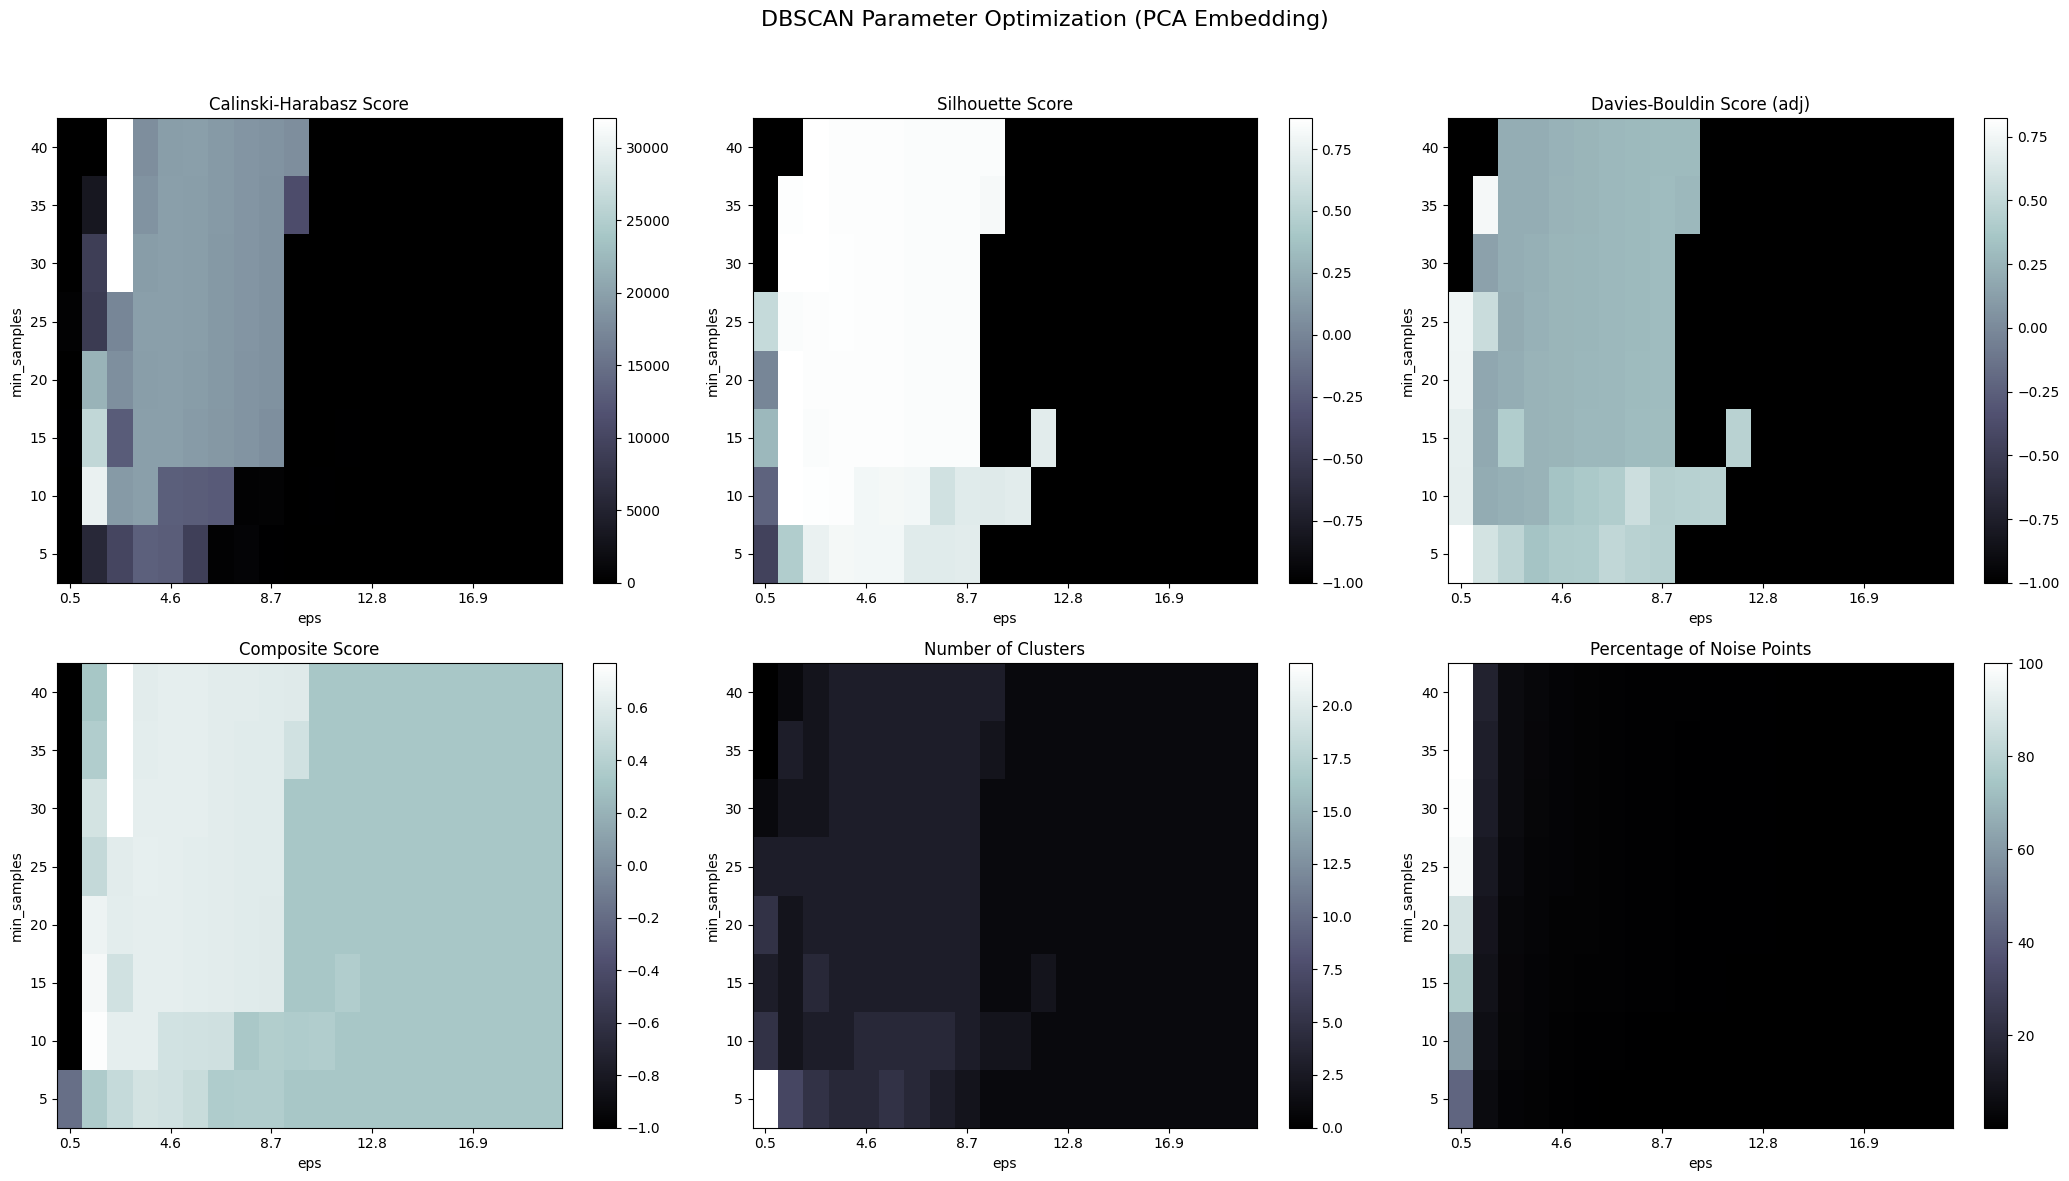


Optimal parameters for PCA based on composite score:
  eps: 2.55
  min_samples: 40
  Composite Score: 0.769
  Number of clusters: 2
  Noise points: 270 (5.4%)

Applying optimal DBSCAN clustering for pca...


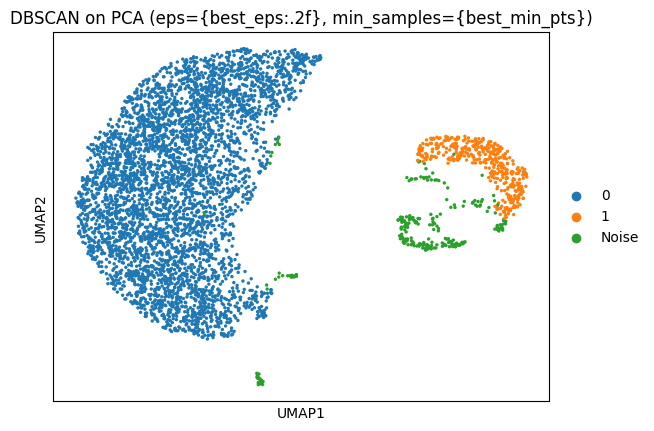


Running DBSCAN optimization with tsne embeddings...


Optimizing TSNE: 100%|██████████| 8/8 [00:58<00:00,  7.29s/it]


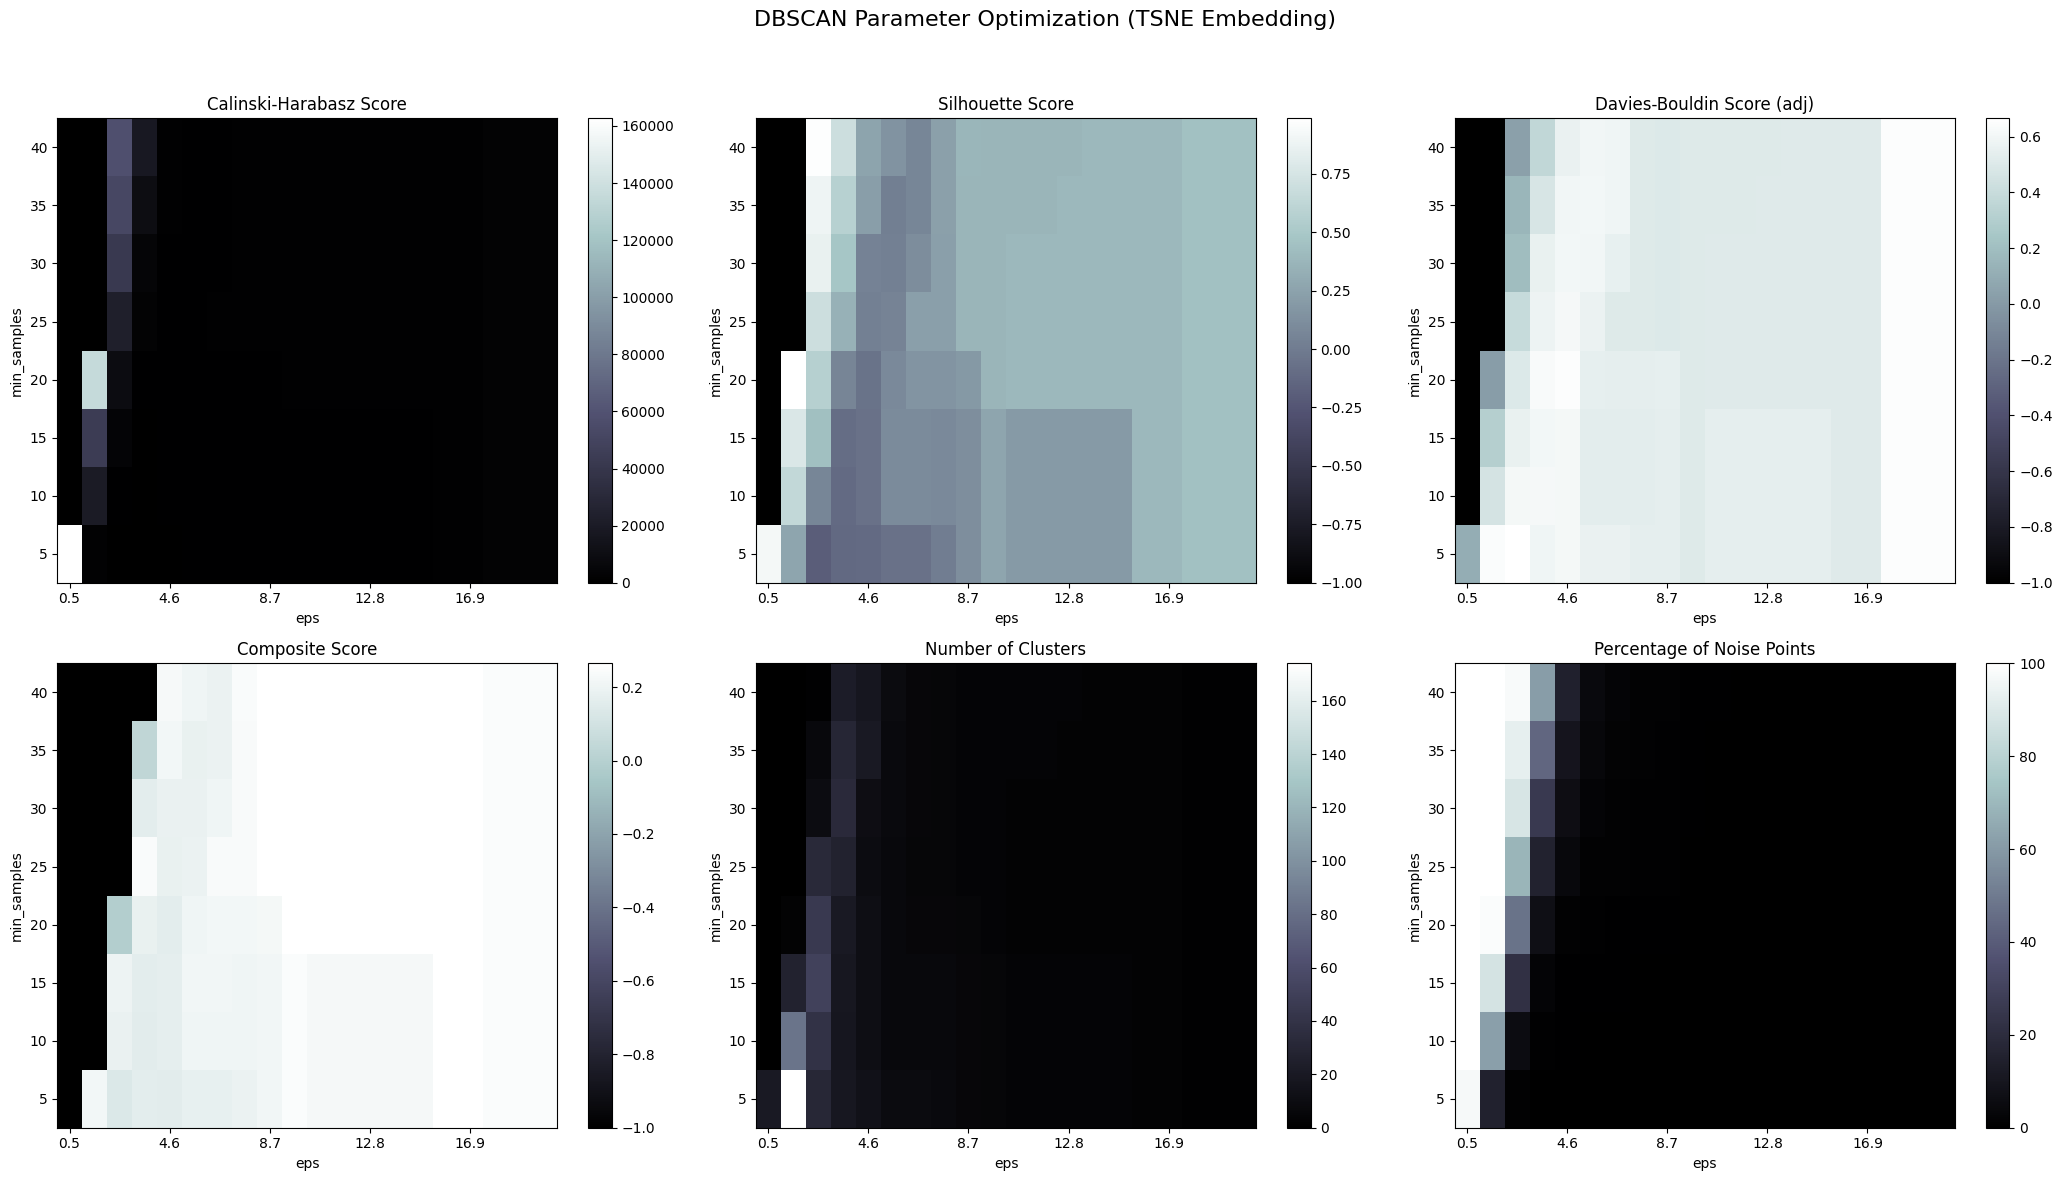


Optimal parameters for TSNE based on composite score:
  eps: 8.71
  min_samples: 40
  Composite Score: 0.265
  Number of clusters: 4
  Noise points: 67 (1.3%)

Applying optimal DBSCAN clustering for tsne...


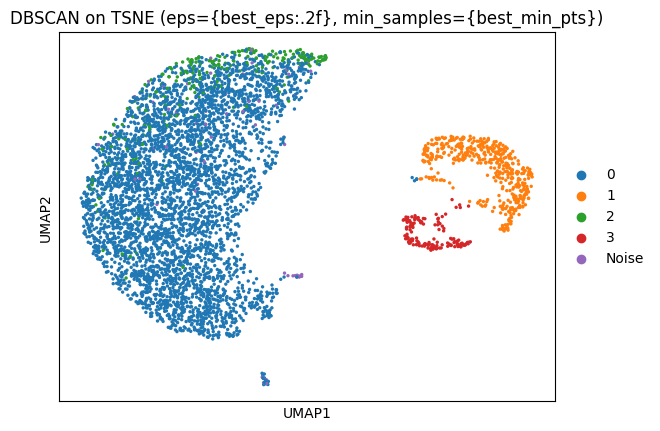


Running DBSCAN optimization with umap embeddings...


Optimizing UMAP: 100%|██████████| 8/8 [01:00<00:00,  7.62s/it]


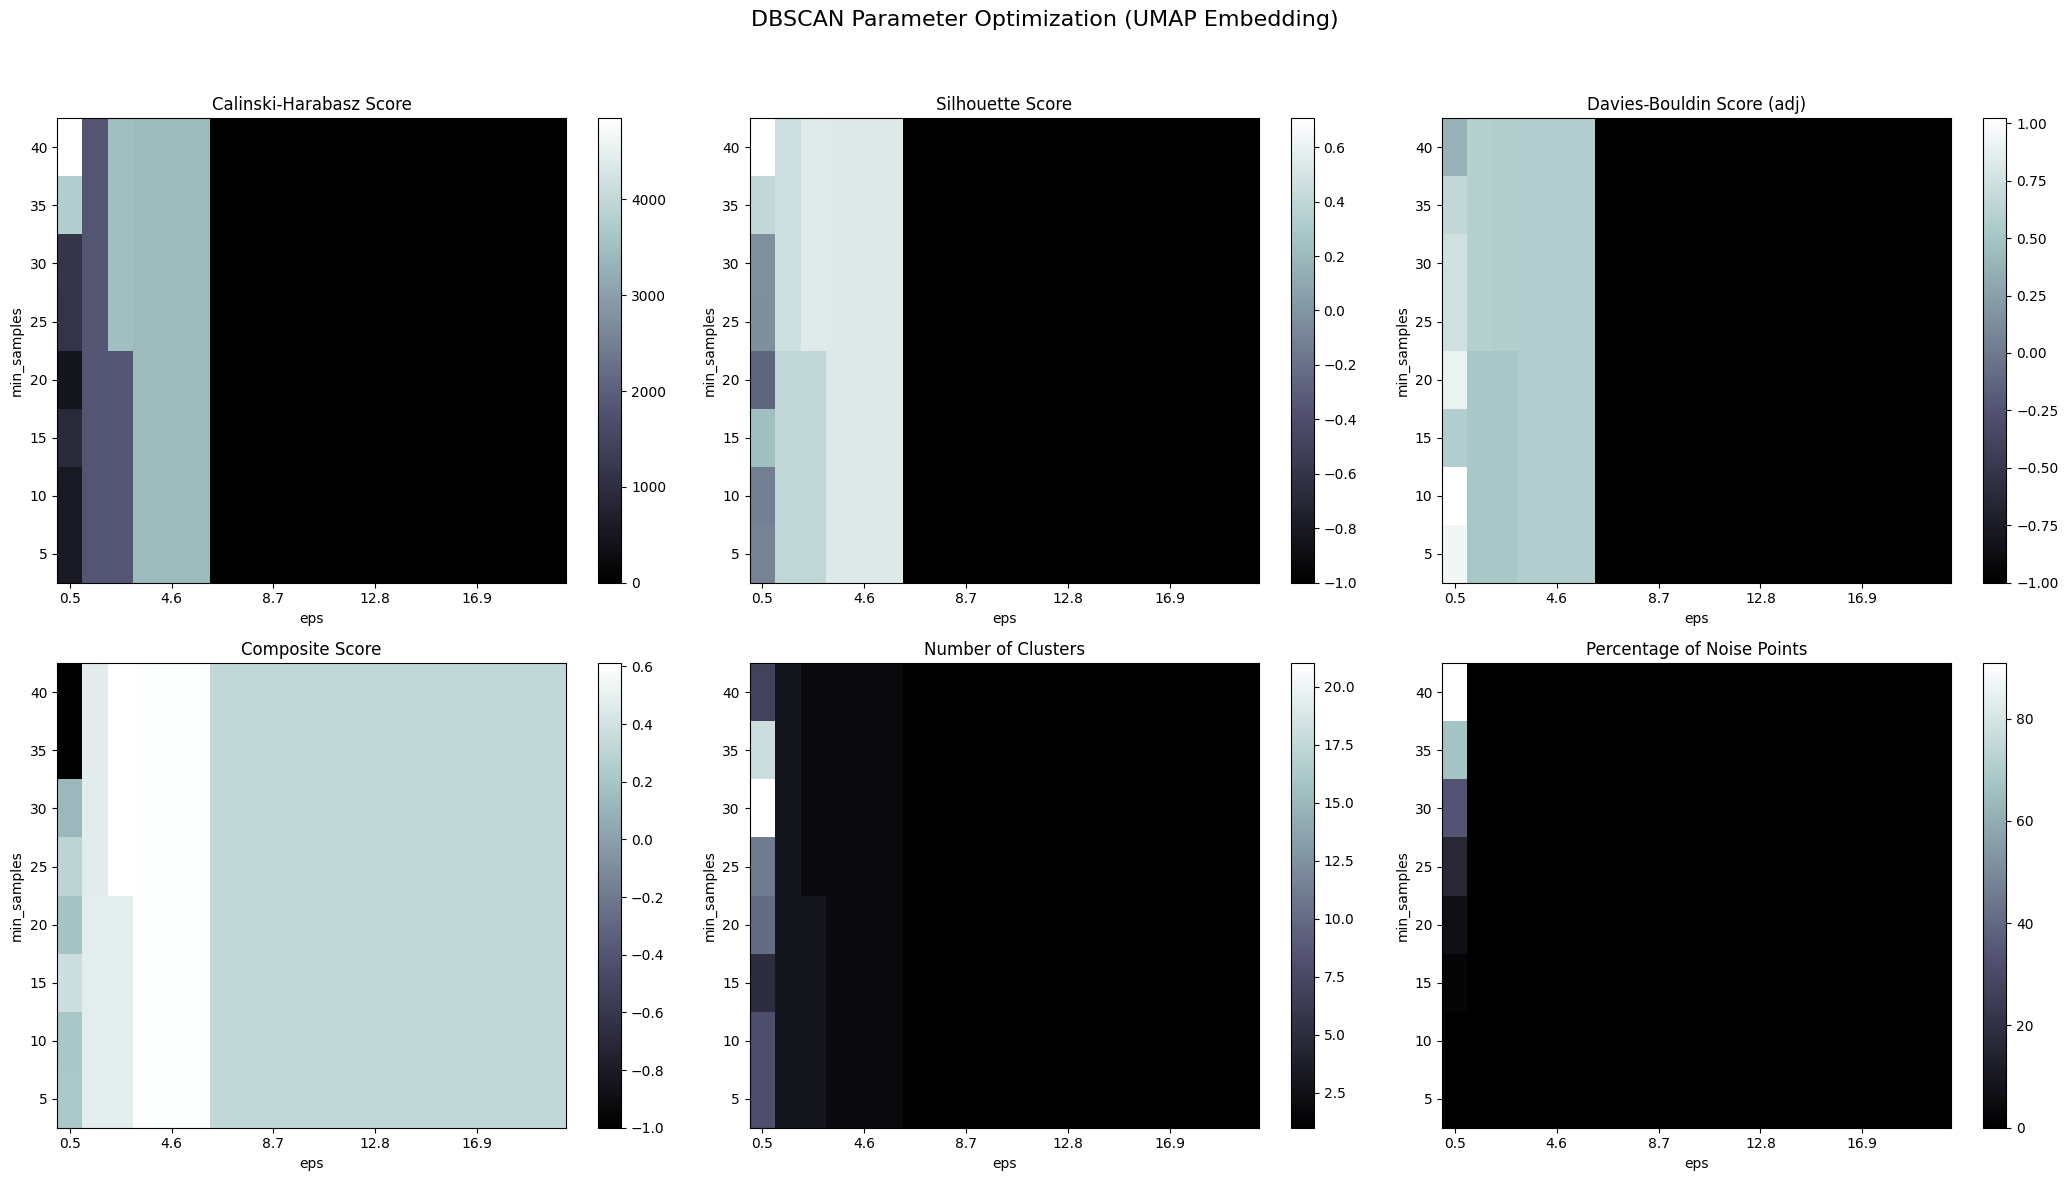


Optimal parameters for UMAP based on composite score:
  eps: 2.55
  min_samples: 25
  Composite Score: 0.610
  Number of clusters: 2
  Noise points: 24 (0.5%)

Applying optimal DBSCAN clustering for umap...


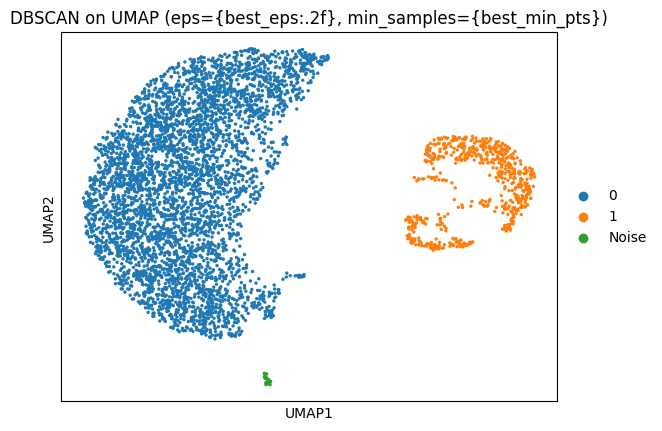


FINAL SUMMARY AND RECOMMENDATIONS:

Embedding Comparison:
Method   Composite Score Clusters   Noise %  eps    min_samples 
----------------------------------------------------------------------
PCA      0.769           2.0        5.4      2.55   40          
TSNE     0.265           4.0        1.3      8.71   40          
UMAP     0.610           2.0        0.5      2.55   25          

RECOMMENDED: PCA embedding with composite score 0.769

Guidelines:
1. Choose the embedding with the highest composite score
2. Ensure noise percentage is reasonable (typically < 30-40%)
3. Visually inspect the clustering results
4. Validate with biological knowledge of your cell types
5. Consider the number of clusters relative to expected cell types

Optimization complete.


In [12]:
noise_threshold_penalize = 15
noise_threshold_discard = 50

min_pts_values = np.arange(5, 45, 5)
eps_values = np.linspace(0.5, 20, 20)

run_dbscan_opt(
    adata,
    n_neighbors,
    elbow,
    min_pts_values,
    eps_values,
    noise_threshold_penalize,
    noise_threshold_discard,
    seed
)